In [4]:
import matplotlib.pyplot as plt
import numpy as np
import glob

In [5]:
def display_images(images,rows,columns,text=[],axis="off"):
    fig = plt.figure(figsize=(30, 20))
    for i in enumerate(images):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i[0]+1)
        # showing image
        plt.imshow(i[1])
        plt.axis(axis)
        try:
            plt.title(text[i[0]])
        except:
            if(i[0]<1):
                print("No text input")
    pass

No text input


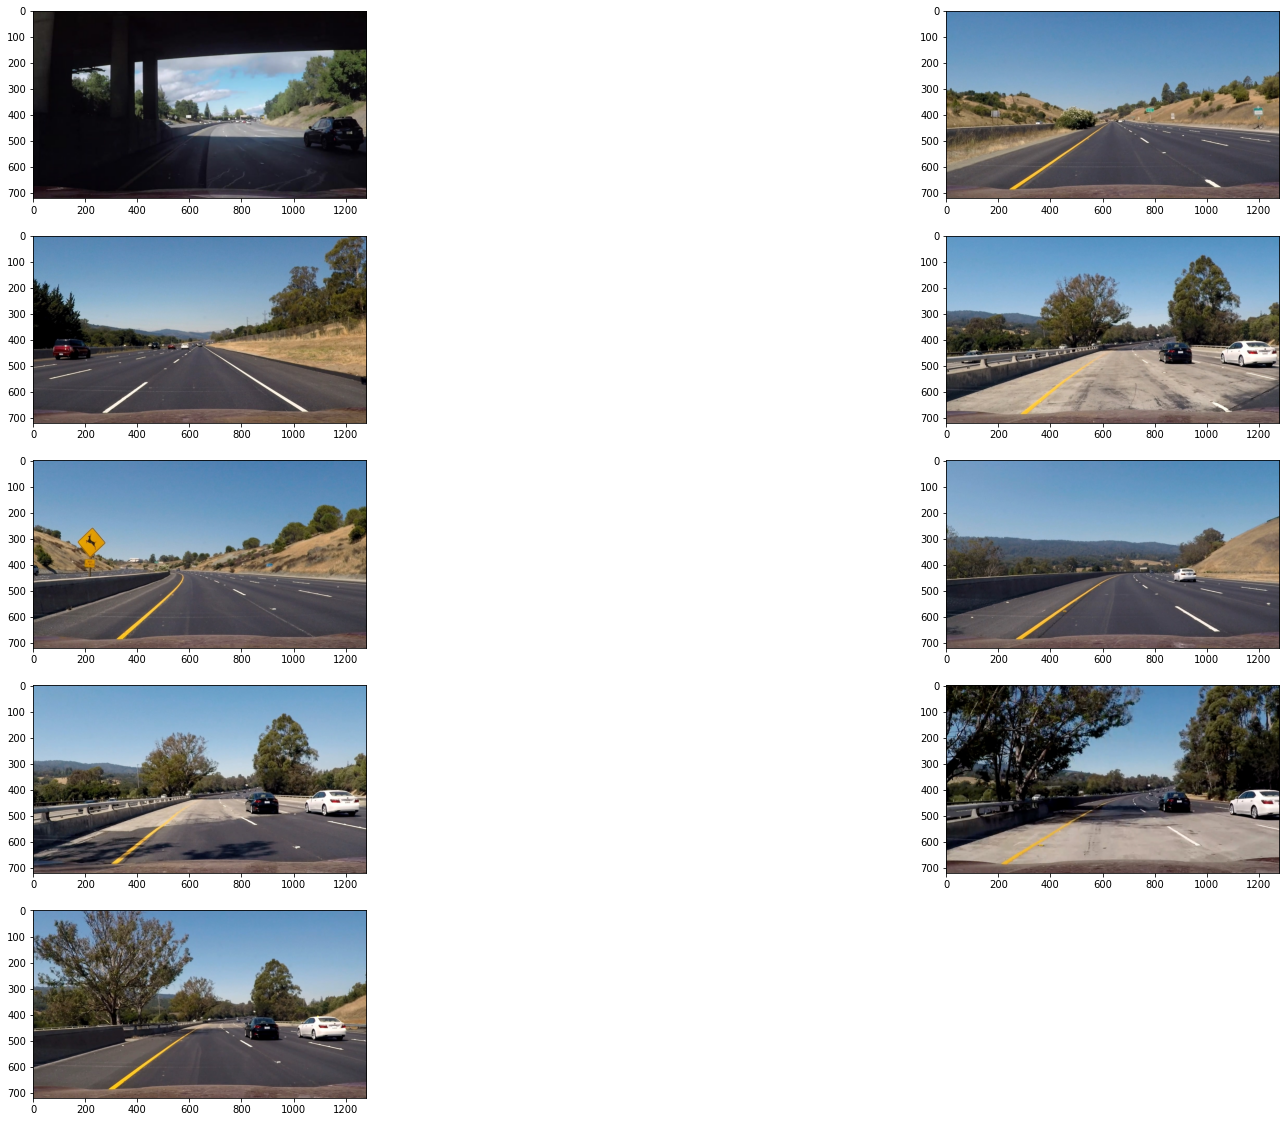

In [9]:
test_images = np.array([plt.imread(i) for i in glob.glob('../test_images/*.jpg')])
display_images(test_images,len(test_images)//2 + 1,2,axis="on")
# display_images(test_images,3,2,axis="on")
    